# Calculating isotherm depth using pure python

Code blocks for project reference.

### Low memory version (no dask)

This code block is for computing isotherm depth per timestep sample. 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

modeldir='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001'
modelsub='/ocn/proc/tseries/month_1/'
filename=f'{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc'

# Open dataset
ds = xr.open_dataset(filename, decode_timedelta=True)
ds = ds.isel(time=0)

target_temp = 20.0
z_t = ds['z_t'].values / 100.0
TEMP = ds['TEMP'].values  # shape: (z_t, nlat, nlon)

depth_at_target = np.full(TEMP.shape[1:], np.nan)  # (nlat, nlon)

for i in range(TEMP.shape[1]):        # nlat
    for j in range(TEMP.shape[2]):    # nlon
        profile = TEMP[:, i, j]
        if np.any(~np.isnan(profile)):
            try:
                depth_at_target[i, j] = np.interp(target_temp, profile[::-1], z_t[::-1])
            except ValueError:
                pass  # temperature outside profile

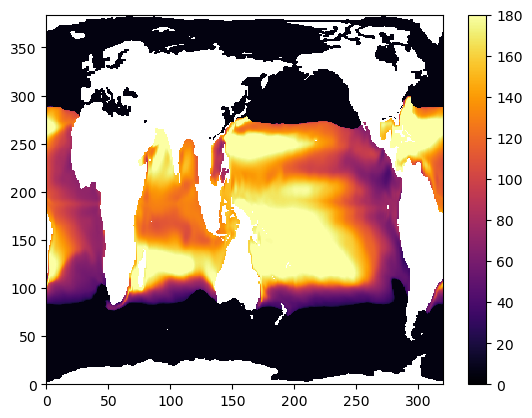

In [2]:
cb = plt.pcolormesh(depth_at_target, vmin=0, vmax=180, cmap='inferno') 
plt.colorbar(cb)
plt.show()

### Low memory version (no dask)

This code block is for computing isotherm depth per timestep sample, but with further clean up (e.g., assignment of nan and formal metadata). 

In [3]:
import xarray as xr
import numpy as np

# --- Config ---
modeldir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001"
modelsub = "/ocn/proc/tseries/month_1/"
filename = f"{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc"

target_temp = 20.0  # °C
time_index = 0

# --- Load one time slice ---
ds = xr.open_dataset(filename, decode_timedelta=True)
T = ds["TEMP"].isel(time=time_index)

# Rename vertical dim to 'z' and convert its coordinate from cm -> m
T = T.rename({"z_t": "z"})
T = T.assign_coords(z=(T["z"] / 100.0))
T["z"].attrs.update(units="m", long_name="depth")

# --- First downward-crossing interpolation of the target isotherm ---
S = T - target_temp
crossing = (S >= 0) & (S.shift(z=-1) < 0)     # True at the upper level of a crossing pair
has_cross = crossing.any("z")
k = crossing.argmax("z")                       # first crossing index along z

# Bracketing (k, k+1) values using vectorized indexing
T0 = T.isel(z=k)
T1 = T.shift(z=-1).isel(z=k)
Z0 = T["z"].isel(z=k)
Z1 = T["z"].shift(z=-1).isel(z=k)

denom = T1 - T0
depth_iso = xr.where(
    has_cross & np.isfinite(denom),
    Z0 + (target_temp - T0) * (Z1 - Z0) / denom,
    np.nan
)

depth_iso = depth_iso.rename(f"depth_at_{int(target_temp)}c").assign_attrs(
    units="m",
    long_name=f"Depth of {target_temp}°C isotherm (first downward crossing)"
)

# Example quicklook / save
# depth_iso.plot()
# depth_iso.to_netcdf(f"isotherm_depth_{int(target_temp)}c.nc")

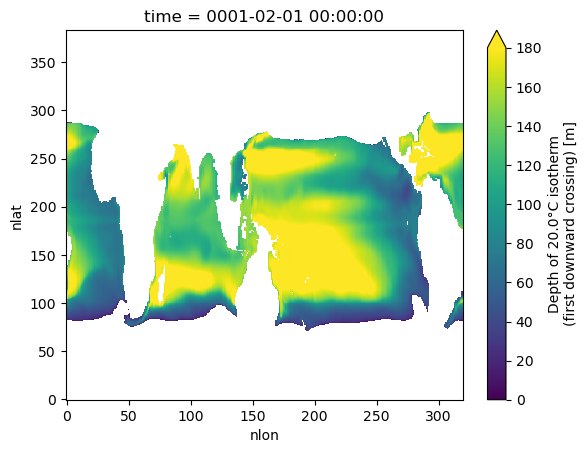

In [4]:
depth_iso.plot.pcolormesh(vmin=0, vmax=180)

### Dask/parallel version

Needs to be run on a job and with dask.

In [ ]:
import xarray as xr
import numpy as np

def depth_of_isotherm_all_times(T_in, target):
    """
    Compute depth of the target isotherm for all times, vectorized over the grid.

    Parameters
    ----------
    T_in : xarray.DataArray
        Temperature with dims ('time', 'z_t', 'nlat', 'nlon') or ('z_t','nlat','nlon').
        POP 'z_t' is expected (in cm).
    target : float or sequence of floats
        Isotherm temperature(s) in °C. If a sequence, returns an extra dim 'iso'.

    Returns
    -------
    depth_iso : xarray.DataArray
        Depth (m) of the first downward crossing of the isotherm.
        Dims: same as T_in minus 'z_t'; plus 'iso' if multiple targets.
        Values are NaN where no crossing occurs.
    """
    # Ensure we have a 'z' dim with meters
    T = T_in.rename({"z_t": "z"}) if "z_t" in T_in.dims else T_in
    T = T.assign_coords(z=(T["z"] / 100.0))
    T["z"].attrs.update(units="m", long_name="depth")

    # Broadcast target(s)
    if np.ndim(target) == 0:
        # scalar target, keep as plain float (xarray will broadcast)
        targets = None
        S = T - target
    else:
        # multiple targets -> add an 'iso' dimension
        targets = xr.DataArray(np.asarray(target), dims=["iso"], name="iso_values")
        S = T.expand_dims(iso=targets.sizes["iso"]) - targets[:, None, None, None]

    # Find first downward crossing along depth: S>=0 at z_k and S<0 at z_{k+1}
    crossing = (S >= 0) & (S.shift(z=-1) < 0)  # True at upper level of the crossing pair
    has_cross = crossing.any("z")
    k = crossing.argmax("z")  # index of first True along z (0 if none; we’ll mask by has_cross)

    # Gather bracketing levels z_k and z_{k+1}
    T0 = T.isel(z=k)
    T1 = T.shift(z=-1).isel(z=k)
    Z0 = T["z"].isel(z=k)
    Z1 = T["z"].shift(z=-1).isel(z=k)

    # Interpolate: Z = Z0 + (target - T0) * (Z1 - Z0) / (T1 - T0)
    denom = (T1 - T0)

    if targets is None:
        tgt = target
    else:
        # Align target values to T0’s dims (time, nlat, nlon, iso or iso, time, nlat, nlon depending on order)
        tgt = targets
        # Make sure broadcasting matches T0
        for d in T0.dims:
            if d not in tgt.dims:
                tgt = tgt.broadcast_like(T0)

    depth_iso = xr.where(
        has_cross & np.isfinite(denom),
        Z0 + (tgt - T0) * (Z1 - Z0) / denom,
        np.nan
    )

    # Nice naming/attrs
    if targets is None:
        depth_iso = depth_iso.rename(f"depth_at_{int(target)}c")
        long_name = f"Depth of {target}°C isotherm (first downward crossing)"
    else:
        depth_iso = depth_iso.rename("depth_of_isotherm")
        long_name = "Depth of isotherms (first downward crossing)"
        depth_iso = depth_iso.assign_coords(iso=targets.values)

    return depth_iso.assign_attrs(units="m", long_name=long_name)


# --- Example usage on your file: all times at once ---
modeldir = "/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001"
modelsub = "/ocn/proc/tseries/month_1/"
filename = f"{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc"

ds = xr.open_dataset(filename, decode_timedelta=True)  # optionally add chunks for dask
T_all = ds["TEMP"]  # dims: time, z_t, nlat, nlon

# Single isotherm for all times
depth20 = depth_of_isotherm_all_times(T_all, 20.0)

# Multiple isotherms at once (returns extra 'iso' dim)
depth_multi = depth_of_isotherm_all_times(T_all, [10.0, 15.0, 20.0, 25.0])

# Quick checks:
# depth20.isel(time=0).plot()         # map at first time
# depth_multi.sel(iso=20.0).plot()    # should match depth20
# depth20.to_netcdf("depth_20C_alltimes.nc")

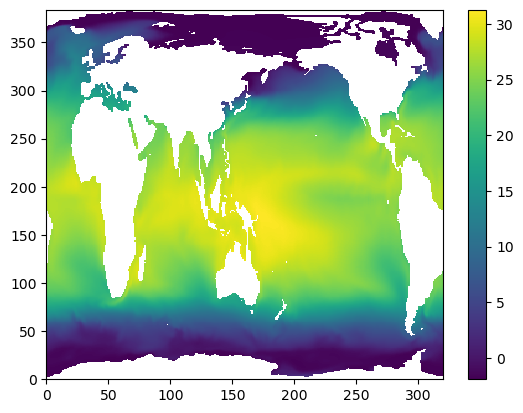

In [19]:
cb = plt.pcolormesh(TEMP[0])
plt.colorbar(cb)
plt.show()

In [27]:
ds['TEMP'].isel(time=0).interp

<xarray.DataArray 'TEMP' (z_t: 60, nlat: 384, nlon: 320)> Size: 29MB
[7372800 values with dtype=float32]
Coordinates:
  * z_t      (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 983kB ...
    ULAT     (nlat, nlon) float64 983kB ...
    TLONG    (nlat, nlon) float64 983kB ...
    TLAT     (nlat, nlon) float64 983kB ...
    time     object 8B 0001-02-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean

In [7]:
temp = ds["TEMP"] # Potential Temperature dims: (time, z, y, x)
depth = ds["z_t"] / 100. # depth from surface to midpoint of layer dims: (z,)
kmt = ds["KMT"] # k Index of Deepest Grid Cell on T Grid dims: (y, x)

In [8]:
# Make a Dataset with depth as the *data* and temp as the "coordinate"
depth_as_func = xr.Dataset(
    {"depth": (('time', 'temp', 'nlat', 'nlon'), depth.broadcast_like(temp).values)},
    coords=temp.coords
).assign_coords(temp=temp)

In [9]:
depth_as_func

<xarray.Dataset> Size: 70GB
Dimensions:  (time: 1188, temp: 60, nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t      (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 983kB ...
    ULAT     (nlat, nlon) float64 983kB ...
    TLONG    (nlat, nlon) float64 983kB ...
    TLAT     (nlat, nlon) float64 983kB ...
  * time     (time) object 10kB 0001-02-01 00:00:00 ... 0100-01-01 00:00:00
    temp     (time, z_t, nlat, nlon) float32 35GB ...
Dimensions without coordinates: nlat, nlon
Data variables:
    depth    (time, temp, nlat, nlon) float32 35GB 5.0 5.0 ... 5.375e+03

In [19]:
tmpfile = depth_as_func["depth"].isel(time=500)#.interp(temp=20)

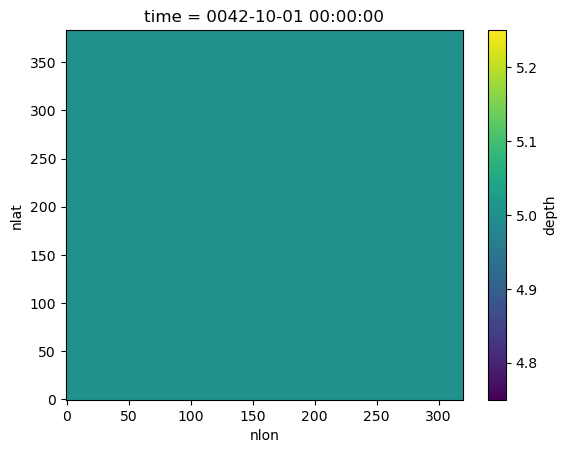

In [22]:
tmpfile.isel(temp=0).plot()

In [ ]:
# Now interpolate in "temp" space
# isotherms = [20, 18, 15, 12, 10, 8, 5]
isotherms = [20]
results = {}

for T in isotherms:
    results[f"depth_of_{T}c"] = depth_as_func["depth"].interp(temp=T)

In [14]:
# Combine into one dataset
newds = xr.Dataset(tmpfile)

# Mask land points (same as Ferret script)
newds = newds.where(kmt > 0, -1e34)

TypeError: unhashable type: 'DataArray'

In [4]:
import xarray as xr
import numpy as np

modeldir='/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850.f09_g17.CMIP6-piControl.001'
modelsub='/ocn/proc/tseries/month_1/'
#f'{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc'

#files = [f"b.e11.B1850LENS.f09_g16.{exp}.pop.h.TEMP.{s}-{e}.nc"
#         for s,e in [
#             ("000101","005012"),("005101","010012"),("010101","015012"),
#             ("015101","020012"),("020101","025012"),("025101","030012"),
#             ("030101","035012"),("035101","040012"),("040101","045012"),
#             ("045101","050012"),("050101","055012"),("055101","060012"),
#             ("060101","065012"),("065101","070012"),("070101","075012"),
#             ("075101","080312")
#         ]]

# Open full time series with dask-backed xarray
#ds = xr.open_mfdataset(files, combine="by_coords", chunks={"time":12})

# single file test
ds = xr.open_mfdataset(
    f'{modeldir}{modelsub}b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.000101-009912.nc', 
    chunks={"time":12},
    decode_timedelta=True
)
ds = ds.chunk({"z_t": -1})  # make full vertical column a single chunk

# Extract temperature and depth axis
temp = ds["TEMP"]     # dims: time, z_t, nlat, nlon
depth = ds["z_t"]     # cm in POP, convert to m
depth = depth / 100.0
depth_1d = ds["z_t"].values / 100  # convert cm → m once

#isotherms = [20, 18, 15, 12, 10, 8, 5]
isotherms = [20, 18, 15]

def find_iso_depth(temp_profile, depth, target):
    mask = np.isnan(temp_profile)
    if mask.all():
        return np.nan
    return np.interp(target, temp_profile[::-1], depth[::-1],
                     left=np.nan, right=np.nan)

# Vectorized wrapper
def compute_isotherms(ds, isotherms):
    results = {}
    for iso in isotherms:
        results[f"depth_of_{iso}c"] = xr.apply_ufunc(
            find_iso_depth,
            ds["TEMP"],
            input_core_dims=[["z_t"]],
            output_core_dims=[[]],
            kwargs={"depth": depth_1d, "target": iso},
            vectorize=True,
            dask="parallelized",
            output_dtypes=[ds["TEMP"].dtype],
            dask_gufunc_kwargs={"allow_rechunk": True}
        )
    return xr.Dataset(results)
# Save output
#iso_ds.to_netcdf("iso20c_python.nc")

In [5]:
ds

<xarray.Dataset> Size: 35GB
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2,
                             z_t: 60, z_w: 60, nlat: 384, nlon: 320,
                             time: 1188, d2: 2, z_t_150m: 15, z_w_top: 60,
                             z_w_bot: 60, lat_aux_grid: 395, moc_z: 61)
Coordinates:
  * z_t                     (z_t) float32 240B 500.0 1.5e+03 ... 5.375e+05
  * z_t_150m                (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 240B 0.0 1e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 240B 1e+03 2e+03 ... 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 2kB -79.49 -78.95 ... 90.0
  * moc_z                   (moc_z) float32 244B 0.0 1e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) object 10kB 0001-02-01 00:00:00 ... 0100-0...
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, nlat,
                                nlon, d2
Data variables: (12/55)
    moc_components          (moc_comp) |S384 1kB dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 2kB dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 768B dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 240B dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 240B dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    salinity_factor         float64 8B ...
    sflux_factor            float64 8B ...
    nsurface_t              float64 8B ...
    nsurface_u              float64 8B ...
    time_bound              (time, d2) object 19kB dask.array<chunksize=(12, 2), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 35GB dask.array<chunksize=(12, 60, 192, 160), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [6]:
iso_ds = compute_isotherms(ds, isotherms)

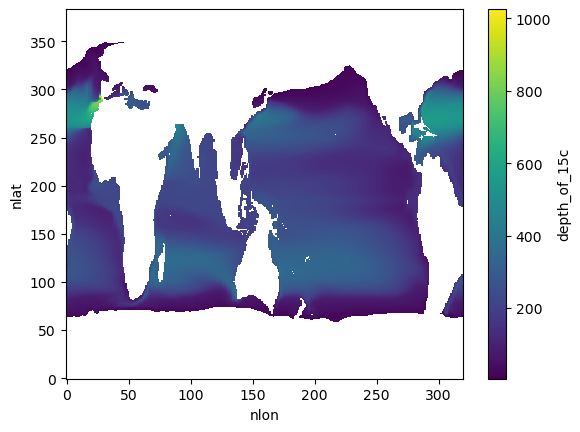

In [15]:
iso_ds.mean('time')['depth_of_15c'].plot()

In [11]:
listof3dtemp = sorted(
    glob.glob(
        modeldirectory+modelsubdir+'b.e21.B1850.f09_g17.CMIP6-piControl.001.pop.h.TEMP.*.nc'
    )
)

In [12]:
da = xr.open_dataset(
    listof3dtemp[0],
    decode_timedelta=True
)['TEMP']

In [13]:
da

<xarray.DataArray 'TEMP' (time: 1188, z_t: 60, nlat: 384, nlon: 320)> Size: 35GB
[8758886400 values with dtype=float32]
Coordinates:
  * z_t      (z_t) float32 240B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 983kB ...
    ULAT     (nlat, nlon) float64 983kB ...
    TLONG    (nlat, nlon) float64 983kB ...
    TLAT     (nlat, nlon) float64 983kB ...
  * time     (time) object 10kB 0001-02-01 00:00:00 ... 0100-01-01 00:00:00
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Potential Temperature
    units:         degC
    grid_loc:      3111
    cell_methods:  time: mean